In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

In [16]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

for col in df.select_dtypes(include=['timedelta64']).columns:
    df[col] = df[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
columnas = ['amount','fee','n_backs','n_fees','n_inc_back','n_inc_fees','to_reimbur', 'type', 'transfer_type','category','charge_moment'] #'user_id',   
X = df[columnas].copy()

# Categoricas
X = pd.get_dummies(X, columns=['type', 'transfer_type', 'category','charge_moment'], drop_first=True, dtype =int)


# Crear el escalador
display(X.head(1))
scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X.columns, index=df.index)
X.fillna(0, inplace=True)
#X.info()


y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
#display(X.head(2))

feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)



,amount,fee,n_backs,n_fees,n_inc_back,n_inc_fees,to_reimbur,type_incident,type_instant_payment,type_postpone,transfer_type_regular,category_nice,category_rejected_direct_debit,charge_moment_before
0,1.0,0.0,0,0,1,0,16.376464,0,0,0,1,0,0,0


La validación cruzada k-fold divide los datos en k subconjuntos (folds), entrena el modelo en k-1 subconjuntos y lo valida en el subconjunto restante. Este proceso se repite k veces, usando cada subconjunto como validación una vez. El resultado final es el promedio de los errores obtenidos en las k iteraciones.

Pasos para Implementar k-Fold en Regresión Logística

1. Importar las Bibliotecas Necesarias: Asegúrate de usar scikit-learn, que tiene herramientas integradas para validación cruzada.
2. Preparar los Datos: Los datos deben estar limpios y preprocesados, como lo hiciste anteriormente.
3. Configurar el Modelo: Define el modelo de regresión logística.
4. Realizar la Validación k-Fold: Utiliza cross_val_score para calcular las métricas de rendimiento (por ejemplo, precisión, exactitud, etc.).

F1-scores en cada fold: [0.9121455  0.92076167 0.91115196 0.91043854 0.91743401]
F1-score promedio: 0.9144
Desviación estándar del F1-score: 0.0040


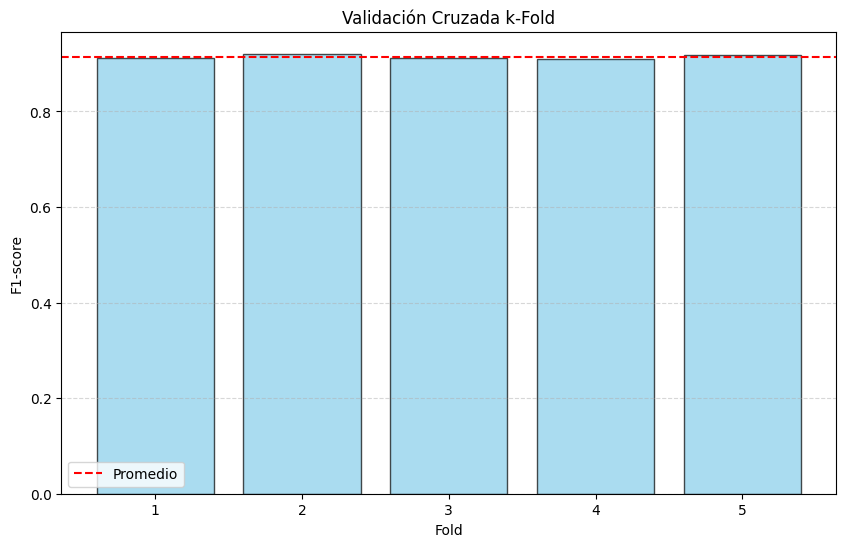

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Configura el modelo de regresión logística
#clf = LogisticRegression(solver='liblinear')

# Configura la validación cruzada k-fold
k = 5  # Número de folds
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Métrica personalizada (por ejemplo, F1-score)
scoring = make_scorer(f1_score)

# Realiza la validación cruzada y calcula la métrica para cada fold
scores = cross_val_score(clf, X, y, cv=kfold, scoring=scoring)

# Imprime los resultados
print(f"F1-scores en cada fold: {scores}")
print(f"F1-score promedio: {scores.mean():.4f}")
print(f"Desviación estándar del F1-score: {scores.std():.4f}")

# Gráfico de las métricas obtenidas en cada fold
plt.figure(figsize=(10, 6))
plt.bar(range(1, k + 1), scores, color="skyblue", edgecolor="black", alpha=0.7)
plt.axhline(scores.mean(), color="red", linestyle="--", label="Promedio")
plt.xlabel("Fold")
plt.ylabel("F1-score")
plt.title("Validación Cruzada k-Fold")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

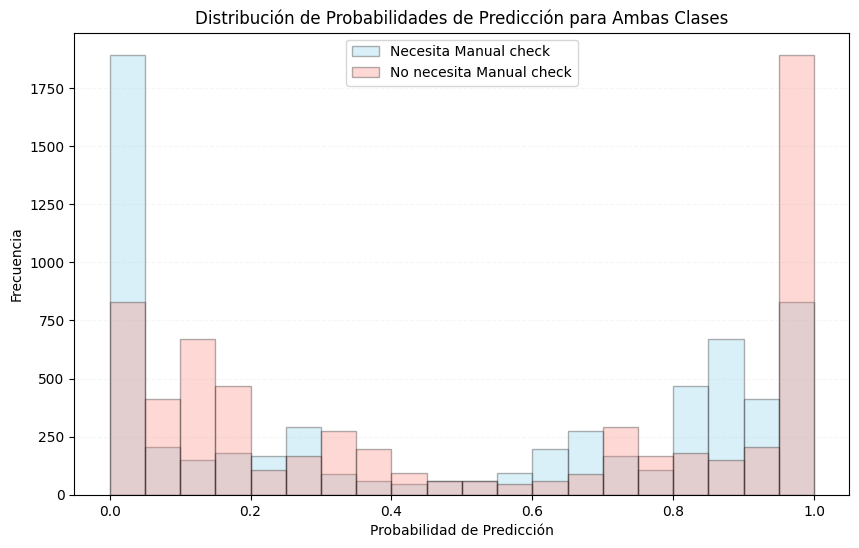

predicciones_probabilidades:
 [[8.38194906e-01 1.61805094e-01]
 [1.20250002e-01 8.79749998e-01]
 [9.59499385e-02 9.04050061e-01]
 [9.97196239e-01 2.80376127e-03]
 [2.32510233e-07 9.99999767e-01]
 [1.43880228e-01 8.56119772e-01]
 [9.15951145e-01 8.40488552e-02]
 [1.39117268e-04 9.99860883e-01]
 [2.42704765e-02 9.75729523e-01]
 [3.05271620e-01 6.94728380e-01]]

Coeficientes del modelo de regresión logística (ordenados por magnitud):
charge_moment_before: -3.4077
n_inc_fees: 3.0436
type_postpone: 3.0385
type_instant_payment: -2.2369
n_backs: -1.4558
type_incident: 1.2761
transfer_type_regular: -1.1882
n_inc_back: 1.1689
n_fees: -1.0776
category_rejected_direct_debit: 0.6400
fee: 0.5478
category_nice: 0.4823
amount: 0.1754
to_reimbur: -0.1699


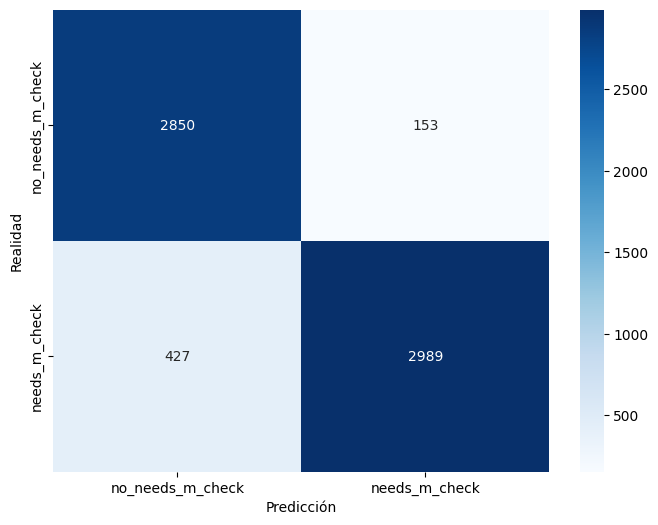

Accuracy: 0.9096432466116218
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      3003
           1       0.95      0.88      0.91      3416

    accuracy                           0.91      6419
   macro avg       0.91      0.91      0.91      6419
weighted avg       0.91      0.91      0.91      6419



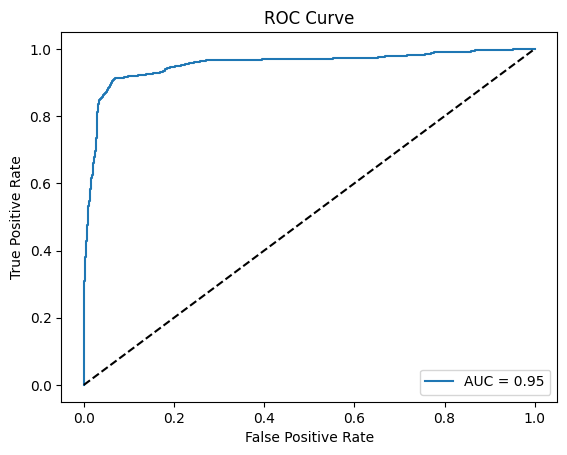

In [18]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

F1-scores en cada fold: [0.9121455  0.92076167 0.91115196 0.91043854 0.91743401]
F1-score promedio: 0.9144
Desviación estándar del F1-score: 0.0040


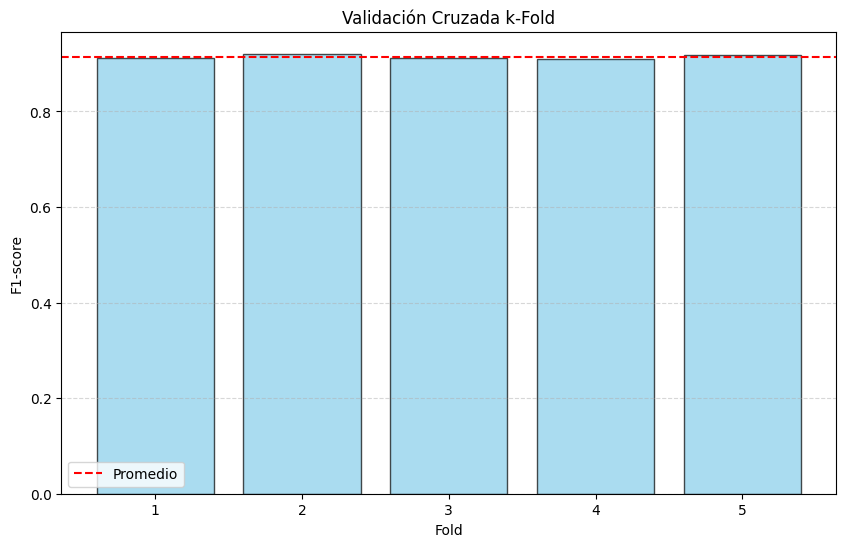

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Configura el modelo de regresión logística
#clf = LogisticRegression(solver='liblinear')

# Configura la validación cruzada k-fold
k = 5  # Número de folds
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Métrica personalizada (por ejemplo, F1-score)
scoring = make_scorer(f1_score)

# Realiza la validación cruzada y calcula la métrica para cada fold
scores = cross_val_score(clf, X, y, cv=kfold, scoring=scoring)

# Imprime los resultados
print(f"F1-scores en cada fold: {scores}")
print(f"F1-score promedio: {scores.mean():.4f}")
print(f"Desviación estándar del F1-score: {scores.std():.4f}")

# Gráfico de las métricas obtenidas en cada fold
plt.figure(figsize=(10, 6))
plt.bar(range(1, k + 1), scores, color="skyblue", edgecolor="black", alpha=0.7)
plt.axhline(scores.mean(), color="red", linestyle="--", label="Promedio")
plt.xlabel("Fold")
plt.ylabel("F1-score")
plt.title("Validación Cruzada k-Fold")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [20]:
# prepare the cross-validation procedure
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate a logistic regression model using repeated k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# create model
#clf = LogisticRegression()
# evaluate model
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.867 (0.033)


>1 mean=0.8660 se=0.011
>2 mean=0.8670 se=0.008
>3 mean=0.8670 se=0.006
>4 mean=0.8668 se=0.006
>5 mean=0.8654 se=0.005
>6 mean=0.8650 se=0.005
>7 mean=0.8647 se=0.004
>8 mean=0.8649 se=0.004
>9 mean=0.8653 se=0.003
>10 mean=0.8657 se=0.003
>11 mean=0.8654 se=0.003
>12 mean=0.8653 se=0.003
>13 mean=0.8652 se=0.003
>14 mean=0.8651 se=0.003
>15 mean=0.8653 se=0.003


/tmp/ipykernel_132236/1003027099.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)


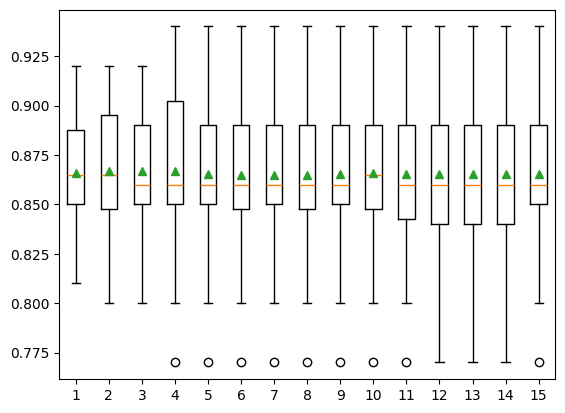

In [21]:
# compare the number of repeats for repeated k-fold cross-validation
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	#model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# create dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# configurations to test
repeats = range(1,16)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X, y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()